In [2]:
%load_ext autoreload
%autoreload 2

# import shap
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm
import copy
from IPython.display import clear_output

from util.util_cnn import CNNModel, data_loaders, first_mnist_batch, test, \
                params_to_filename, params_from_filename, load_mnist_v4_models

from util.naming import *
from util.util_lrp import layerwise_forward_pass, compute_relevancies, LRP_global_mat, calc_mats_batch_functional, forward_and_explain
from util.util_tutorial import heatmap
from util.util_pickle import *
from util.util_data_summary import gridlrp_load_results, gridlrp_print_best_and_worst, gridlrp_plot_metric_terrain, gridlrp_plot_metric_terrain_for_tags, \
llrp_plot_training_for_tags

# pan kessel
from explanations_can_be_manipulated.src.nn.enums import ExplainingMethod, LRPRule
from explanations_can_be_manipulated.src.nn.networks import ExplainableNet
from explanations_can_be_manipulated.src.nn.utils import get_expl, plot_overview, clamp, load_image, make_dir

device = 'cpu'
method = ExplainingMethod.lrp

no display found. Using non-interactive Agg backend


In [3]:
%matplotlib inline

In [4]:
# load data and pretrained models
batch_size = 100

data, target = first_mnist_batch(batch_size=batch_size)
background, background_target = first_mnist_batch(batch_size=batch_size, test=False)

background = background.reshape((-1, 1, 28, 28))
test_images = data[:3].reshape((-1, 1, 28, 28))

shap_config = 'shap__background_size-100__batch_size-10__model-cb1-8-8-8_cb2-16-16-16_seed-0'
test_loader_shap = data_loaders(shapley_values_for=('d3', shap_config), shuffle=False, batch_size=batch_size)

model_dict = load_mnist_v4_models()
model_d3 = model_dict[d3_tag]

100%|██████████| 1555/1555 [00:06<00:00, 233.58it/s]


## Comparing the Operator norm of every LRP backward step to the 'Operator norm' of the normalization step in the end
The multiplied operator norms are much larger than the factor by which the absolute norm dampens the heatmaps. This is esepcially true for gamma=0.

In [62]:
from functools import partial
from util.util_gamma_rule import calc_vals_batch

l_indices=[0,2,4,6,7,9,11,13,14,15]
for i in l_indices:
    print(i, str(layers[i]).split('(')[0])

n_points = 2
gammas = [0, .5]

mat_funcs = [partial(LRP_global_mat, model=model_d3, l_inp=l_inp, l_out=l_inp+1, delete_unactivated_subnetwork=True) for l_inp in l_indices]
LRP__individual_layer = calc_mats_batch_functional(mat_funcs, gammas, data[:n_points].reshape((n_points, -1)))
LRP__individual_layer.shape, LRP__individual_layer[:, :1, :1]

svals__individual_layer, _ = calc_vals_batch(LRP__individual_layer, num_vals=1, tqdm_for="gamma")

0 Conv2d
2 Conv2d
4 Conv2d
6 MaxPool2d
7 Conv2d
9 Conv2d
11 Conv2d
13 MaxPool2d
14 Flatten
15 Conv2d


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [69]:
i_point=0

for i, vals in zip(l_indices, svals__individual_layer[:, i_point, :, 0]):
    print(i, str(layers[i]).split('(')[0], '\t', vals.round(1))

0 Conv2d 	 [2.3 2.3]
2 Conv2d 	 [725.8   2.1]
4 Conv2d 	 [1053.6    2.8]
6 MaxPool2d 	 [1. 1.]
7 Conv2d 	 [205.7   2.5]
9 Conv2d 	 [90.4  3. ]
11 Conv2d 	 [258.4   2.4]
13 MaxPool2d 	 [1. 1.]
14 Flatten 	 [1. 1.]
15 Conv2d 	 [3.7 0.8]


In [73]:
# multiplied operator norms, for two points, for two gammas.
np.product(svals__individual_layer[:, :, :, 0], axis=0).round(2) 

array([[3.08578279e+13, 1.93490000e+02],
       [3.35082642e+13, 1.89740000e+02]])

In [74]:
# ... are much larger than the factor by which the absolute norm dampens the heatmaps. both for gamma=0 ...
model = ExplainableNet(model_d3).eval().to(device)
model.change_lrp_rules(gamma=0, lrp_rule_nl=LRPRule.gamma)
x = data[:10]
heatmap_full, _, _ = get_expl(model, x, method, full=True)
heatmap_full.shape, heatmap_full.abs().sum(axis=(1,2,3))

(torch.Size([10, 1, 28, 28]),
 tensor([122.0199,  49.7096,  37.3286,  28.6131,  53.8422, 128.0465,  94.0852,
          36.6746,  62.0457, 122.5443], grad_fn=<SumBackward1>))

In [75]:
# ... and for gamma=.5 ...
model = ExplainableNet(model_d3).eval().to(device)
model.change_lrp_rules(gamma=0.5, lrp_rule_nl=LRPRule.gamma)
x = data[:10]
heatmap_full, _, _ = get_expl(model, x, method, full=True)
heatmap_full.shape, heatmap_full.abs().sum(axis=(1,2,3))

(torch.Size([10, 1, 28, 28]),
 tensor([13.1671,  7.9691, 14.9577, 16.0967, 18.5357, 14.4384, 22.9635, 13.0728,
         24.0766,  9.3902], grad_fn=<SumBackward1>))

## Reading out the total positive and negative contributions to neurons in a network
This investigates a small idea I had in the end. It led nowhere.

In [5]:
import util.util_tutorial as tut_utils
from util.util_gamma_rule import global_conv_matrix_from_pytorch_layer
from copy import deepcopy

In [89]:

model_dict = load_mnist_v4_models()
model_d3 = model_dict[d3_tag]

In [7]:
A, A_pos, A_neg, layers = layerwise_forward_pass(model_d3, data, pos_neg=True)
L = len(layers)

A_shapes = [a.shape[1:] for a in A]

0 torch.Size([8, 1, 3, 3])
2 torch.Size([8, 8, 3, 3])
4 torch.Size([8, 8, 5, 5])
7 torch.Size([16, 8, 5, 5])
9 torch.Size([16, 16, 3, 3])
11 torch.Size([16, 16, 3, 3])
15 torch.Size([10, 256, 1, 1])


In [8]:
i = 2


In [16]:

conv_layer = deepcopy(model_d3.seq[i])
conv_layer.bias = None

out_img = conv_layer.forward(A[i][:1])

# direct computation of the global transiton matrix
trans = global_conv_matrix_from_pytorch_layer(conv_layer, A_shapes[i], A_shapes[i+1])
out_vec = trans @ A[i][:1].flatten().detach().numpy()

# check equality of results between matrix representation and conv layer.
a, b = out_img.detach().flatten(), out_vec
assert np.allclose(a, b, atol=1e-4), f"Output result by global transition matrix is unequal to direct pytorch computation. Max difference: {(a-b).abs().max()}"

In [17]:
trans.toarray().shape

(6272, 6272)

In [11]:
len(np.unique(W.toarray()))

577

In [140]:
len(np.unique(conv_layer.weight.data))

576

In [85]:
z = A[i+1][0].flatten().detach().numpy()
p = A_pos[i+1][0].flatten().detach().numpy()
n = A_neg[i+1][0].flatten().detach().numpy()

mask = z > 0

z = z[mask]
p = p[mask]
n = n[mask]
W = trans.toarray()[mask]



z.shape, W.shape

((3137,), (3137, 6272))

In [86]:
j = 80
K, J = W.shape

ks = np.arange(K)[W[:, j] != 0]
ks

array([  79,   80,   81,  107,  108,  109,  135,  136,  137,  888,  889,
        890,  916,  917,  918,  944,  945,  946, 1672, 1673, 1674, 1700,
       1701, 1702, 1724, 1725, 1726, 2619, 2620, 2621, 2642, 2643, 2644,
       2663, 2664, 2665])

In [87]:
pairs = np.stack((np.repeat(ks, len(ks)), np.tile(ks, len(ks)))).T # .reshape(len(ks), len(ks), 2)
pairs = pairs[pairs[:, 0] != pairs[:, 1]]
pairs.shape, pairs

((1260, 2),
 array([[  79,   80],
        [  79,   81],
        [  79,  107],
        ...,
        [2665, 2644],
        [2665, 2663],
        [2665, 2664]]))

In [88]:
p_pairs = p[pairs]
n_pairs = n[pairs]

In [105]:
frac_g0 = p_pairs+n_pairs
frac_g0 = frac_g0[:, 0] / frac_g0[:, 1]
frac_gi = p_pairs
frac_gi = frac_gi[:, 0] / frac_gi[:, 1]

In [104]:
frac_g0

array([[0.16468266, 0.16468266],
       [0.16468266, 0.16468266],
       [0.16468266, 0.16468266],
       ...,
       [0.11550689, 0.11550689],
       [0.11550689, 0.11550689],
       [0.11550689, 0.11550689]], dtype=float32)

In [135]:
frac_w = W[pairs, j]
frac_w = frac_w[:, 0] / frac_w[:, 1] # todo check order
frac_w.shape, frac_w

((1260,),
 array([ 0.72735756,  1.55067917,  0.52695174, ..., -0.14613444,
        -0.27492972,  0.12327069]))

In [136]:
l = np.minimum(frac_g0, frac_gi)
u = np.maximum(frac_g0, frac_gi)

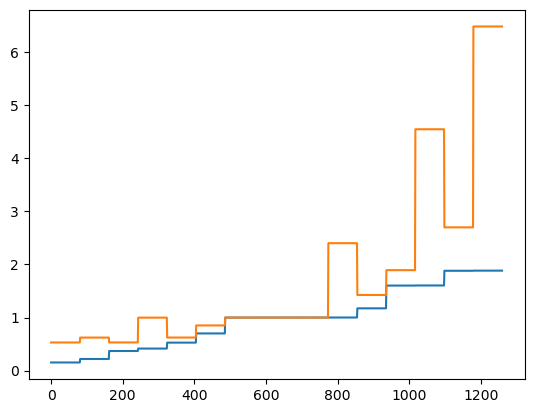

In [137]:
ord = np.argsort(l)
plt.plot(l[ord])
plt.plot(u[ord])
# plt.plot(frac_w[ord])

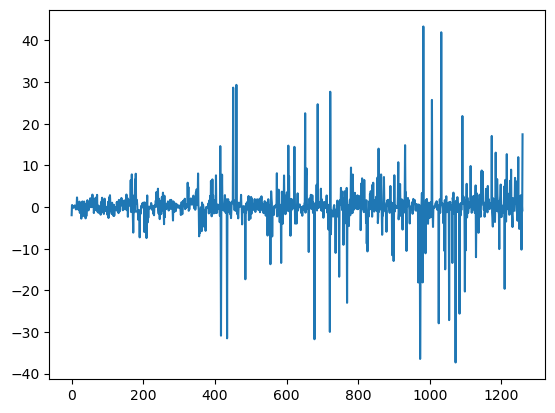

In [138]:
x = np.arange(len(l))
y = frac_w[ord]
plt.plot(frac_w[ord])

In [139]:
# frac of negative filter entries
np.mean(W[:, j][W[:, j] != 0] < 0)

0.6666666666666666

In [140]:
# as their is a bias of filter weights to be of a certain sign, more than half of the fractions of filter weights are positive
# in the remaining 45%, of combinationg gamma=inf minimizes the distance.
np.mean(frac_w > 0)

0.5428571428571428

In [141]:
# handle positive cases only:
mask = frac_w > 0
p_frac_w = frac_w[mask]

p_frac_g0 = frac_g0[mask]
p_frac_gi = frac_gi[mask]

p_l = l[mask]
p_u = u[mask]

In [142]:
np.mean(p_frac_w > p_u)

0.4342105263157895

In [143]:
diff_to_g0 = np.abs(p_frac_w - p_frac_g0)
diff_to_gi = np.abs(p_frac_w - p_frac_gi)

np.mean(diff_to_g0 > diff_to_gi)

0.5409356725146199

In [144]:
l, u

(array([1., 1., 1., ..., 1., 1., 1.], dtype=float32),
 array([1., 1., 1., ..., 1., 1., 1.], dtype=float32))

In [145]:
## In the subset where the weights have the same sign, 11% of cases can be optimized by gamma in ]0, inf[
np.mean(np.logical_and(p_l <= p_frac_w, p_frac_w <= p_u))

0.13157894736842105

#### Going back to full picture

In [146]:
mask = np.logical_and(l <= frac_w, frac_w <= u)
f_frac_w = frac_w[mask]
f_p_pairs = p_pairs[mask]
f_n_pairs = n_pairs[mask]

In [147]:
(f_frac_w * f_p_pairs[:, 1] - f_p_pairs[:, 0]) / (f_n_pairs[:, 0] - f_frac_w * f_n_pairs[:, 1])

array([0.08178144, 0.02394903, 0.52076172, 0.02409773, 0.88169018,
       0.5828347 , 0.5927909 , 0.66835076, 0.58684893, 0.643311  ,
       0.87270127, 0.27906567, 0.81845348, 0.11820721, 0.5828347 ,
       0.6816883 , 0.58749678, 0.65284363, 0.9140333 , 0.5927909 ,
       0.68030047, 0.58587648, 0.65138593, 0.91316588, 0.05121899,
       0.64477097, 0.50655609, 0.38133427, 0.46842992, 0.80674788,
       0.95509749, 0.78898741, 0.73571884, 0.5272542 , 0.9788051 ,
       0.37171209, 0.99231915, 0.81845348, 0.27906567, 0.11820721,
       0.73571884, 0.5706427 , 0.94039591, 0.95509749, 0.4474293 ,
       0.90616409, 0.08178144, 0.66835076, 0.6816883 , 0.68030047,
       0.50655609, 0.5272542 , 0.74323314, 0.58684893, 0.58749678,
       0.58587648, 0.38133427, 0.9788051 , 0.9845092 , 0.55160884,
       0.02394903, 0.643311  , 0.65284363, 0.65138593, 0.46842992,
       0.37171209, 0.66810384, 0.99056825, 0.52076172, 0.02409773,
       0.87270127, 0.9140333 , 0.91316588, 0.05121899, 0.80674